<a href="https://colab.research.google.com/github/erily12/MemeProject/blob/master/SolarModelLSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%tensorflow_version 2.x
import tensorflow as tf
print(tf.__version__)

In [0]:
!pip install keras
!pip install -U scikit-learn
!pip install seaborn

Requirement already up-to-date: scikit-learn in /usr/local/lib/python3.6/dist-packages (0.21.3)


In [0]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
#import keras

plt.style.use('fivethirtyeight')

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## **Importing The Dataset**

In [0]:
dataset = pd.read_csv('/SolarPrediction.csv')
dataset = dataset.sort_values(['UNIXTime'], ascending = [True])
dataset.head()

,UNIXTime,Data,Time,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,TimeSunRise,TimeSunSet
7416,1472724008,9/1/2016 12:00:00 AM,00:00:08,2.58,51,30.43,103,77.27,11.25,06:07:00,18:38:00
7415,1472724310,9/1/2016 12:00:00 AM,00:05:10,2.83,51,30.43,103,153.44,9.00,06:07:00,18:38:00
7414,1472725206,9/1/2016 12:00:00 AM,00:20:06,2.16,51,30.43,103,142.04,7.87,06:07:00,18:38:00
7413,1472725505,9/1/2016 12:00:00 AM,00:25:05,2.21,51,30.43,103,144.12,18.00,06:07:00,18:38:00
7412,1472725809,9/1/2016 12:00:00 AM,00:30:09,2.25,51,30.43,103,67.42,11.25,06:07:00,18:38:00


## **Feature Engineering**
First step upon importing the dataset was to convert time and date parameters into a more useful format and add some coloumns that may be useful for visualisation, modelling and analysis.

In [0]:
from datetime import datetime
from pytz import timezone
import pytz
hawaii= timezone('Pacific/Honolulu')
dataset.index =  pd.to_datetime(dataset['UNIXTime'], unit='s')
dataset.index = dataset.index.tz_localize(pytz.utc).tz_convert(hawaii)
dataset['MonthOfYear'] = dataset.index.strftime('%m').astype(int)
dataset['DayOfYear'] = dataset.index.strftime('%j').astype(int)
dataset['WeekOfYear'] = dataset.index.strftime('%U').astype(int)
dataset['TimeOfDay(h)'] = dataset.index.hour
dataset['TimeOfDay(m)'] = dataset.index.hour*60 + dataset.index.minute
dataset['TimeOfDay(s)'] = dataset.index.hour*60*60 + dataset.index.minute*60 + dataset.index.second
dataset['TimeSunRise'] = pd.to_datetime(dataset['TimeSunRise'], format='%H:%M:%S')
dataset['TimeSunSet'] = pd.to_datetime(dataset['TimeSunSet'], format='%H:%M:%S')
dataset['DayLength(s)'] = dataset['TimeSunSet'].dt.hour*60*60 \
                           + dataset['TimeSunSet'].dt.minute*60 \
                           + dataset['TimeSunSet'].dt.second \
                           - dataset['TimeSunRise'].dt.hour*60*60 \
                           - dataset['TimeSunRise'].dt.minute*60 \
                           - dataset['TimeSunRise'].dt.second
dataset.drop(['Data','Time','TimeSunRise','TimeSunSet'], inplace=True, axis=1)
dataset.head()

,UNIXTime,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,MonthOfYear,DayOfYear,WeekOfYear,TimeOfDay(h),TimeOfDay(m),TimeOfDay(s),DayLength(s)
UNIXTime,,,,,,,,,,,,,,
2016-09-01 00:00:08-10:00,1472724008,2.58,51,30.43,103,77.27,11.25,9,245,35,0,0,8,45060
2016-09-01 00:05:10-10:00,1472724310,2.83,51,30.43,103,153.44,9.00,9,245,35,0,5,310,45060
2016-09-01 00:20:06-10:00,1472725206,2.16,51,30.43,103,142.04,7.87,9,245,35,0,20,1206,45060
2016-09-01 00:25:05-10:00,1472725505,2.21,51,30.43,103,144.12,18.00,9,245,35,0,25,1505,45060
2016-09-01 00:30:09-10:00,1472725809,2.25,51,30.43,103,67.42,11.25,9,245,35,0,30,1809,45060


## **Feature Visualisation**
Next, in order to get a better understanding of the data, hourly and monthly means of several variables were visualised using bar plots.

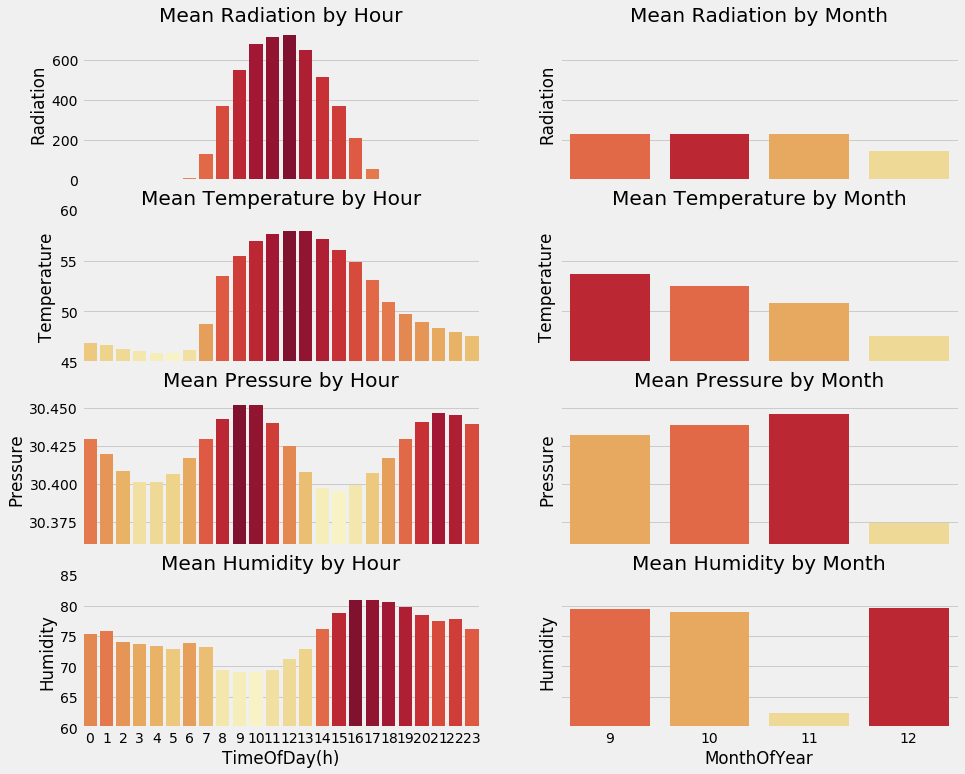

In [0]:
grouped_m=dataset.groupby('MonthOfYear').mean().reset_index()
grouped_w=dataset.groupby('WeekOfYear').mean().reset_index()
grouped_d=dataset.groupby('DayOfYear').mean().reset_index()
grouped_h=dataset.groupby('TimeOfDay(h)').mean().reset_index()

f, ((ax1, ax2), (ax3, ax4), (ax5, ax6), (ax7, ax8)) = plt.subplots(4, 2, sharex='col', sharey='row', figsize=(14,12))
ax3.set_ylim(45,60)
ax5.set_ylim(30.36,30.46)
ax7.set_ylim(60,85)

ax1.set_title('Mean Radiation by Hour')
pal = sns.color_palette("YlOrRd_r", len(grouped_h))
rank = grouped_h['Radiation'].argsort().argsort() 
g = sns.barplot(x="TimeOfDay(h)", y='Radiation', data=grouped_h, palette=np.array(pal[::-1])[rank], ax=ax1)
ax1.set_xlabel('')

ax2.set_title('Mean Radiation by Month')
pal = sns.color_palette("YlOrRd_r", len(grouped_m))
rank = grouped_m['Radiation'].argsort().argsort() 
g = sns.barplot(x="MonthOfYear", y='Radiation', data=grouped_m, palette=np.array(pal[::-1])[rank], ax=ax2)
ax2.set_xlabel('')

ax3.set_title('Mean Temperature by Hour')
pal = sns.color_palette("YlOrRd_r", len(grouped_h))
rank = grouped_h['Temperature'].argsort().argsort() 
g = sns.barplot(x="TimeOfDay(h)", y='Temperature', data=grouped_h, palette=np.array(pal[::-1])[rank], ax=ax3)
ax3.set_xlabel('')

ax4.set_title('Mean Temperature by Month')
pal = sns.color_palette("YlOrRd_r", len(grouped_m))
rank = grouped_m['Temperature'].argsort().argsort() 
g = sns.barplot(x="MonthOfYear", y='Temperature', data=grouped_m, palette=np.array(pal[::-1])[rank], ax=ax4)
ax4.set_xlabel('')

ax5.set_title('Mean Pressure by Hour')
pal = sns.color_palette("YlOrRd_r", len(grouped_h))
rank = grouped_h['Pressure'].argsort().argsort() 
g = sns.barplot(x="TimeOfDay(h)", y='Pressure', data=grouped_h, palette=np.array(pal[::-1])[rank], ax=ax5)
ax5.set_xlabel('')

ax6.set_title('Mean Pressure by Month')
pal = sns.color_palette("YlOrRd_r", len(grouped_m))
rank = grouped_m['Pressure'].argsort().argsort() 
g = sns.barplot(x="MonthOfYear", y='Pressure', data=grouped_m, palette=np.array(pal[::-1])[rank], ax=ax6)
ax6.set_xlabel('')

ax7.set_title('Mean Humidity by Hour')
pal = sns.color_palette("YlOrRd_r", len(grouped_h))
rank = grouped_h['Humidity'].argsort().argsort() 
g = sns.barplot(x="TimeOfDay(h)", y='Humidity', data=grouped_h, palette=np.array(pal[::-1])[rank], ax=ax7)

ax8.set_title('Mean Humidity by Month')
pal = sns.color_palette("YlOrRd_r", len(grouped_m))
rank = grouped_m['Humidity'].argsort().argsort() 
g = sns.barplot(x="MonthOfYear", y='Humidity', data=grouped_m, palette=np.array(pal[::-1])[rank], ax=ax8)

plt.show()

In [0]:
dataset.head()

,UNIXTime,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,MonthOfYear,DayOfYear,WeekOfYear,TimeOfDay(h),TimeOfDay(m),TimeOfDay(s),DayLength(s)
UNIXTime,,,,,,,,,,,,,,
2016-09-01 00:00:08-10:00,1472724008,2.58,51,30.43,103,77.27,11.25,9,245,35,0,0,8,45060
2016-09-01 00:05:10-10:00,1472724310,2.83,51,30.43,103,153.44,9.00,9,245,35,0,5,310,45060
2016-09-01 00:20:06-10:00,1472725206,2.16,51,30.43,103,142.04,7.87,9,245,35,0,20,1206,45060
2016-09-01 00:25:05-10:00,1472725505,2.21,51,30.43,103,144.12,18.00,9,245,35,0,25,1505,45060
2016-09-01 00:30:09-10:00,1472725809,2.25,51,30.43,103,67.42,11.25,9,245,35,0,30,1809,45060


In [0]:
train_radiation = dataset['Radiation']
df = train_radiation
df.shape

(32686,)

In [0]:
train_radiation.head()

In [0]:
# LSTM Network for Regression
#Output = do_lstm_model(train_radiation, 
             'Radiation',
              50,
              1, 
              0.70)

Train on 21897 samples
21897/21897 - 53s - loss: 0.0038
Train on 21897 samples
21897/21897 - 50s - loss: 0.0033
Train on 21897 samples
21897/21897 - 50s - loss: 0.0032
Train on 21897 samples
21897/21897 - 50s - loss: 0.0032
Train on 21897 samples
21897/21897 - 50s - loss: 0.0031
Train Score: 105.27 RMSE
Test Score: 74.26 RMSE


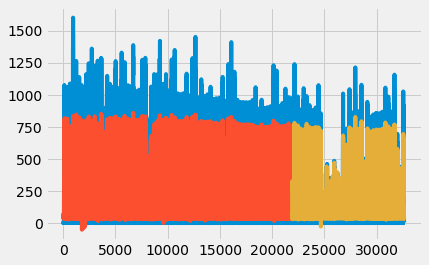

In [59]:
import math
from tensorflow.python.keras.layers import Dense
from tensorflow.python.keras import Sequential
from tensorflow.python.keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error


#ts = 'Radiation'
epochs = 50
look_back = 1
train_fraction = 0.67

  # Convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    """
    Create the dataset
    """
    dataX = []
    dataY = []
    for i in range(len(dataset)-look_back-1):
      a = dataset[i:(i+look_back), 0]
      dataX.append(a)
      dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

  # Fix random seed for reproducibility
np.random.seed(7)

  # Get dataset
dataset = df.values
dataset = dataset.astype('float32')

  # Normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset.reshape(-1, 1))
  
  # Split into train and test sets
train_size = int(len(dataset) * train_fraction)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
  
  # Reshape into X=t and Y=t+1
look_back = look_back
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
  
type_ = 'b'

  # Reshape input to be [samples, time steps, features]
if type_ == 'a':
  trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
  testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1))
elif type_ == 'c':
  trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
  testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1))
else:
  trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
  testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
  
  # Create and fit the LSTM network
batch_size = 1
model = Sequential()
  
if type_ == 'a':
  model.add(LSTM(4, input_shape=(look_back, 1)))
elif type_ == 'b':
  model.add(LSTM(4, batch_input_shape=(batch_size, look_back, 1), stateful=True))
elif type_ == 'c':
  model.add(LSTM(4, batch_input_shape=(batch_size, look_back, 1), stateful=True, return_sequences=True))
  model.add(LSTM(4, batch_input_shape=(batch_size, look_back, 1), stateful=True))
else:
  model.add(LSTM(4, input_shape=(1, look_back)))
  
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

if type_ == 'b' or type_ == 'c':
  for i in range(5):
    model.fit(trainX, trainY, epochs=1, batch_size=batch_size, verbose=2, shuffle=False)
    model.reset_states()
else:
  model.fit(trainX, 
              trainY, 
              epochs = epochs, 
              batch_size = 1, 
              verbose = 2)
  
  # Make predictions
if type_ == 'b' or type_ == 'c':
  trainPredict = model.predict(trainX, batch_size=batch_size)
  testPredict = model.predict(testX, batch_size=batch_size)
else:
  trainPredict = model.predict(trainX)
  testPredict = model.predict(testX)
  
  # Invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
  
  # Calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))
  
  # Shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
  
  # Shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
  
  # Plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()
plt.close()
  